In [35]:
import torch
import math
from torch.utils import data
import matplotlib.pyplot as plt
from scipy import io

import torch.nn.functional as F
from torch import nn
import numpy as np
from scipy.sparse import coo_matrix
import seaborn as sns


In [3]:
def peaks(data_size, shuffle=True, nf=2, input_ch=None):
    data = io.loadmat('Peaks.mat')
    Peaks = data['a']
    
    labels_all = Peaks.copy()
    for i in range(labels_all.shape[0]):
        for j in range(labels_all.shape[1]):
            if Peaks[i][j] < -4:
                labels_all[i][j] = 0
            elif Peaks[i][j] < -2:
                labels_all[i][j] = 1
            elif Peaks[i][j] < 2:
                labels_all[i][j] = 2
            elif Peaks[i][j] < 6:
                labels_all[i][j] = 3
            else:
                labels_all[i][j] = 4
    
    data_original = torch.zeros(256*256, 2, 1)
    X,Y = torch.meshgrid(torch.linspace(-3, 3, 256), torch.linspace(-3, 3, 256))
    data_original[:,0,:] = torch.reshape(Y,(1,-1,1))
    data_original[:,1,:] = torch.reshape(X,(1,-1,1))
    
    n_class = 5
    class_size = data_size / n_class

    data2d = torch.zeros(data_size, 2, 1)
    labels = torch.zeros(data_size,1)
    for i in range(n_class):
        a = np.reshape(labels_all==i,(-1,1))
        cnt = np.sum(a)
        b = torch.zeros(cnt,2,1)
        b[:,0,:] = data_original[:,0][a].unsqueeze(1)
        b[:,1,:] = data_original[:,1][a].unsqueeze(1)
        cnt_rd=[]
        j=0
        while j<class_size:
            rd = np.random.randint(cnt, size=1)
            if rd not in cnt_rd:
                cnt_rd.append(rd)
                data2d[int(i*class_size+j),:,:] = b[rd,:,:]
                labels[int(i*class_size+j),:] = i
                j+=1
                
    if nf != 2:
        data2d = _data_extension(data2d, nf, input_ch)
        
    return data2d, labels

In [4]:
data_size = 5000
train_data_size = 2500
test_data_size = data_size - train_data_size
nf = 8
n_classes = 5
data_gen = peaks

In [5]:
def _data_extension(data2d, nf, input_ch=None):
    if nf < 2:
        print("Dimension not valid")
        return
    elif nf % 2 == 1:
        print("Using odd dimension nf")
    data_size = data2d.shape[0]
    if input_ch is not None:
        # input_ch is a list of two elements. The elements indicate where the data enters.
        idx_x = input_ch[0]
        idx_y = input_ch[1]
    else:
        idx_x = 0
        idx_y = nf-1
    data2d = torch.cat((torch.zeros(data_size, idx_x-0, 1),
                        data2d[:, 0:1, :],
                        torch.zeros(data_size, idx_y-idx_x-1, 1),
                        data2d[:, 1:2, :],
                        torch.zeros(data_size, nf-1-idx_y, 1)), 1)
    return data2d

In [6]:
data2d, labels = data_gen(data_size,nf=nf)

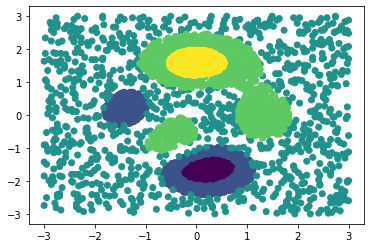

In [7]:
plt.scatter(data2d.data.numpy()[:,0],data2d.data.numpy()[:,nf-1],c=labels)
plt.show()

In [8]:
class Dataset(data.Dataset):

    def __len__(self):
        return len(self.list_ids)

    def __init__(self, list_ids, data_in, labels):
        self.list_ids = list_ids
        self.data = data_in
        self.labels = labels

    def __getitem__(self, index):

        idx = self.list_ids[index]

        x = self.data[idx, :, :]
        y = self.labels[idx, :]

        return x, y

partition = {'train': range(0, data_size, 2),
             'test': range(1, data_size, 2)}
training_set = Dataset(partition['train'], data2d, labels)

In [9]:
training_generator = data.DataLoader(training_set, batch_size=125, shuffle=True)

## Integrator

In [10]:
t_end = 5
n_layers = 512
h = t_end / n_layers

In [11]:
# # Select training parameters
alpha = 1e-6 #5e-4
alphac = 1e-4
learning_rate = 0.5e-1 #0.5e-1
learning_rate_c = 1e-1
max_iteration = 50
max_in_iteration = 100

# define network structure and optimizer
batch_size = 125
training_set = Dataset(partition['train'], data2d, labels)
training_generator = data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

In [12]:
class H1(nn.Module):
    # Hamiltonian neural network, as presented in [1,2].
    # H_1-DNN and H_2-DNN
    # General ODE: \dot{y} = J(y,t) K(t) \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    #   J(y,t) = J_1 = [ 0 I ; -I 0 ]  or  J(y,t) = J_2 = [ 0 1 .. 1 ; -1 0 .. 1 ; .. ; -1 -1 .. 0 ].
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True, select_j='J1',n_classes=5):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features
        self.n_classes = n_classes # number of classes

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers-1)
            b = torch.randn(self.nf, 1, self.n_layers-1)
            final_K = torch.randn(self.nf, self.n_classes,1)
            final_b = torch.randn(self.n_classes, 1, 1)
        else:
            K = torch.ones(self.nf, self.nf, self.n_layers-1)
            b = torch.zeros(self.nf, 1, self.n_layers-1)
            final_K = torch.ones(self.nf, self.n_classes, 1)
            final_b = torch.zeros(self.n_classes, 1, 1)
        
        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)
        self.final_K = nn.Parameter(final_K, True)
        self.final_b = nn.Parameter(final_b, True)

        if select_j == 'J1':
            j_identity = torch.eye(self.nf//2)
            j_zeros = torch.zeros(self.nf//2, self.nf//2)
            self.J = torch.cat((torch.cat((j_zeros, j_identity), 0), torch.cat((- j_identity, j_zeros), 0)), 1)
        else:
            j_aux = np.hstack((np.zeros(1), np.ones(self.nf-1)))
            J = j_aux
            for j in range(self.nf-1):
                j_aux = np.hstack((-1 * np.ones(1), j_aux[:-1]))
                J = np.vstack((J, j_aux))
            self.J = torch.tensor(J, dtype=torch.float32)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
        
        for j in range(ini, end-1):
            Y = Y + self.h * F.linear(self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j])), torch.matmul(self.J, self.K[:, :, j]))
            
        NNoutput = Y.transpose(1, dim-1)

        return NNoutput

In [13]:
class Classification(nn.Module):
    def __init__(self, nf=2, nout=n_classes):
        super().__init__()
        self.nout = nout
        self.W = nn.Parameter(torch.zeros(self.nout, 1), True)
        self.mu = nn.Parameter(torch.zeros(1, self.nout), True)
        self.act = nn.LogSoftmax(dim=1)

    def forward(self, Y0):
        # Y = Y0.transpose(1, 2)
        Y = Y0.unsqueeze(1).unsqueeze(2)
        NNoutput = self.act(F.linear(Y, self.W, self.mu).squeeze(1))
        return NNoutput

In [14]:
def regularization(alpha, h, K, b):
    # Regularization function as introduced in [1]
    n_layers = K.shape[-1]
    loss = 0
    for j in range(n_layers - 1):
        loss = loss + alpha * h * (1 / 2 * torch.norm(K[:, :, j + 1] - K[:, :, j]) ** 2 +
                                   1 / 2 * torch.norm(b[:, :, j + 1] - b[:, :, j]) ** 2)
    return loss

## Training

In [15]:
model = H1(n_layers, t_end, nf=nf, select_j='J1',n_classes=n_classes)

In [16]:
loss_func = nn.NLLLoss()
optimizer_k = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
def compute_H(y,K,b):
    n_layers = K.shape[-1]
    H = torch.sum(torch.log(torch.cosh(F.linear(
                y.squeeze(2), K[:, :, n_layers-1].transpose(0, 1), b[:, 0, n_layers-1]))),1)
    # H -= torch.mean(H)
    return H

In [18]:
for epoch in range(max_iteration):

    training_iterator = iter(training_generator)

    for i_k in range(int(data2d[partition['train']].size(0) / training_generator.batch_size)):

        local_samples, local_labels = next(training_iterator)

        model_c = Classification(nf=nf)
        optimizer_w = torch.optim.Adam(model_c.parameters(), lr=learning_rate_c)
        
        with torch.no_grad():
            YN = model(local_samples)
        
        optimizer_k.zero_grad()
        K = model.getK()
        b = model.getb()
        
        for i_w in range(max_in_iteration):  # Inner iteration
            optimizer_w.zero_grad()
            loss = loss_func(model_c(compute_H(YN,K,b)), torch.Tensor.long(local_labels).squeeze(1))
            loss = loss + alphac * 0.5 * (torch.norm(model_c.W) ** 2 + torch.norm(model_c.mu) ** 2)
            loss.backward()
            optimizer_w.step()

        loss = loss_func(model_c(compute_H(model(local_samples),K,b)), torch.Tensor.long(local_labels).squeeze(1))
        loss += regularization(alpha, h, K, b)
        loss.backward()
        li = list(optimizer_k.state)
        if not (len(li) == 0):
            for ii in range(2):
                optimizer_k.state[li[ii]]['step'] = epoch
        optimizer_k.step()

    if epoch % 10 == 0 or epoch == max_iteration-1:
        model_c = Classification(nf=nf)
        optimizer_w = torch.optim.Adam(model_c.parameters(), lr=learning_rate_c)
        with torch.no_grad():
            YN = model(local_samples)
        for i_w in range(max_in_iteration):  # Inner iteration
            optimizer_w.zero_grad()
            loss = loss_func(model_c(compute_H(YN,K,b)), torch.Tensor.long(local_labels).squeeze(1))
            loss = loss + alphac * 0.5 * (torch.norm(model_c.W) ** 2 + torch.norm(model_c.mu) ** 2)
            loss.backward()
            optimizer_w.step()
            acc = (torch.exp(model_c(compute_H(model(local_samples),K,b))).data.max(1, keepdim=True)[1] == local_labels).sum().numpy() / batch_size
        print('\tTrain Epoch: {:2d} - Loss: {:.6f} - Accuracy: {:.2f}%'.format(epoch, loss, acc*100))

# Train classification layer with all the data

# Accuracy results

with torch.no_grad():
    train_acc = (torch.exp(model_c(compute_H(model(data2d[partition['train'], :, :]),K,b))).data.max(1, keepdim=True)[1] == labels[partition['train'], :]
                 ).sum().numpy() / train_data_size
    test_acc = (torch.exp(model_c(compute_H(model(data2d[partition['test'], :, :]),K,b))).data.max(1, keepdim=True)[1] == labels[partition['test'], :]
                 ).sum().numpy() / test_data_size
    
print('\tTrain Accuracy: {:.2f}%'.format(train_acc*100))
print('\tTest Accuracy: {:.2f}%'.format(test_acc*100))

	Train Epoch:  0 - Loss: 0.903817 - Accuracy: 59.20%
	Train Epoch: 10 - Loss: 0.397542 - Accuracy: 95.20%
	Train Epoch: 20 - Loss: 0.447239 - Accuracy: 91.20%
	Train Epoch: 30 - Loss: 0.449393 - Accuracy: 93.60%
	Train Epoch: 40 - Loss: 0.443541 - Accuracy: 89.60%
	Train Epoch: 49 - Loss: 0.456428 - Accuracy: 91.20%
	Train Accuracy: 92.16%
	Test Accuracy: 90.84%


In [19]:
a = torch.exp(model_c(compute_H(model(data2d[partition['test'], :, :]),K,b)))
torch.sum(a[100]) #.data.max(1, keepdim=True)[1]

tensor(1.0000, grad_fn=<SumBackward0>)

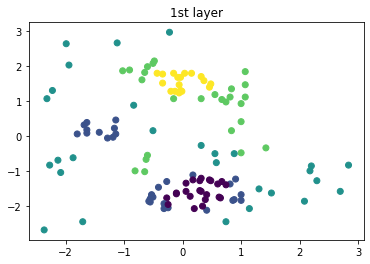

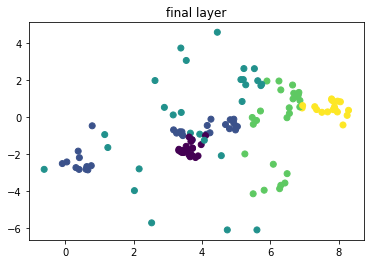

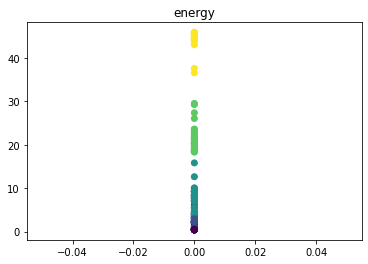

In [20]:
plt.scatter(local_samples.data.numpy()[:,0],local_samples.data.numpy()[:,nf-1],c=local_labels)
plt.title('1st layer')
plt.show()

plt.scatter(YN.data.numpy()[:,0],YN.data.numpy()[:,nf-1],c=local_labels)
plt.title('final layer')
plt.show()

plt.scatter(np.zeros(125),compute_H(YN,K,b).data.numpy(),c=local_labels)
plt.title('energy')
plt.show()

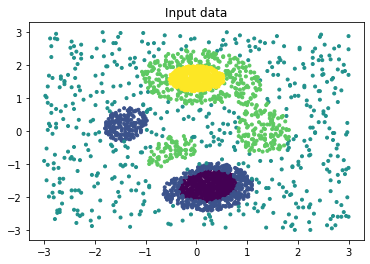

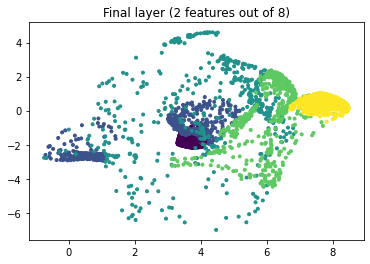

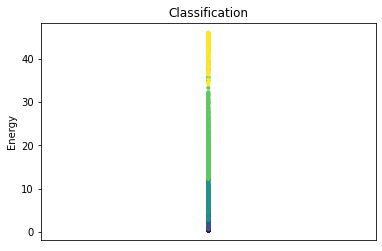

In [31]:
plt.scatter(data2d[partition['test'], :, :].data.numpy()[:,0],data2d[partition['test'], :, :].data.numpy()[:,nf-1],c=labels[partition['test'], :], marker='.')
plt.title('Input data')
plt.show()

plt.scatter(model(data2d[partition['test'], :, :]).squeeze(2).data.numpy()[:,0],model(data2d[partition['test'], :, :]).squeeze(2).data.numpy()[:,nf-1],c=labels[partition['test'], :], marker='.')
# plt.plot([-4,6],[4,-4],color='r')
plt.title('Final layer (2 features out of 8)')
plt.show()

plt.scatter(np.zeros(test_data_size),compute_H(model(data2d[partition['test'], :, :]),K,b).data.numpy(),c=labels[partition['test'], :], marker='.')
plt.ylabel("Energy")
plt.title('Classification')
plt.xticks([])
plt.show()

In [32]:
data2d_0 = []
data2d_1 = []
data2d_2 = []
data2d_3 = []
data2d_4 = []
for i in range(test_data_size):
    if labels[partition['test'], :][i]==0:
        data2d_0.append(data2d[partition['test'], :, :][i])
    if labels[partition['test'], :][i]==1:
        data2d_1.append(data2d[partition['test'], :, :][i])
    if labels[partition['test'], :][i]==2:
        data2d_2.append(data2d[partition['test'], :, :][i])
    if labels[partition['test'], :][i]==3:
        data2d_3.append(data2d[partition['test'], :, :][i])
    if labels[partition['test'], :][i]==4:
        data2d_4.append(data2d[partition['test'], :, :][i])

In [33]:
data2d_0_0 = torch.cat(data2d_0, dim=1).T.unsqueeze(2)
data2d_1_1 = torch.cat(data2d_1, dim=1).T.unsqueeze(2)
data2d_2_2 = torch.cat(data2d_2, dim=1).T.unsqueeze(2)
data2d_3_3 = torch.cat(data2d_3, dim=1).T.unsqueeze(2)
data2d_4_4 = torch.cat(data2d_4, dim=1).T.unsqueeze(2)


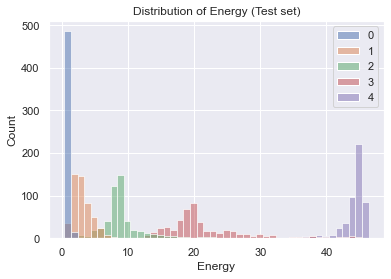

In [40]:
sns.histplot(data=[compute_H(model(data2d_0_0),K,b).data.numpy(),compute_H(model(data2d_1_1),K,b).data.numpy(),
            compute_H(model(data2d_2_2),K,b).data.numpy(),compute_H(model(data2d_3_3),K,b).data.numpy(),compute_H(model(data2d_4_4),K,b).data.numpy()],
            binwidth=1)
plt.xlabel('Energy')
plt.title('Distribution of Energy (Test set)');

In [37]:
sns.set()